In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import scipy

import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline
sns.set_theme(style="darkgrid")

ModuleNotFoundError: No module named 'numpy.testing.nosetester'

In [215]:
import datetime
from pandas.tseries.holiday import USFederalHolidayCalendar

In [216]:
import statsmodels.api as sm

# from statsmodels.tsa.stattools import adfuller
# from statsmodels.tsa.arima_model import ARIMA


In [217]:
from sklearn.metrics import mean_squared_error

In [218]:
from sklearn.preprocessing import StandardScaler

In [219]:
from pmdarima.arima import auto_arima

In [220]:
import tensorflow as tf

In [221]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam


## load data

In [222]:
#load the master files
bike_ts= pd.read_csv('master_df_bike_weather.csv', parse_dates=['date'])
testbike_ts= pd.read_csv('master_test_df_weather.csv',parse_dates = ['date'])

In [223]:
bike_ts = bike_ts.set_index('date', drop = False)
testbike_ts = testbike_ts.set_index('date', drop = False)

In [224]:
bike_ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30622 entries, 2014-01-01 to 2015-12-31
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  30622 non-null  datetime64[ns]
 1   start_station_id      30622 non-null  int64         
 2   start_station_name    30622 non-null  object        
 3   rev                   30622 non-null  float64       
 4   dow                   30622 non-null  int64         
 5   quarter               30622 non-null  int64         
 6   day                   30622 non-null  int64         
 7   month                 30622 non-null  int64         
 8   year                  30622 non-null  int64         
 9   is_holiday            30622 non-null  int64         
 10  Week_sin              30622 non-null  float64       
 11  Week_cos              30622 non-null  float64       
 12  log_rev               30622 non-null  float64       
 13 

In [225]:
testbike_ts.head()

,date,month,day,start_station_name,pred,start_station_id,year,dow,quarter,is_holiday,...,HumidityAvg_Percent,HumidityLow_Percent,VisibilityHigh_Miles,VisibilityAvg_Miles,VisibilityLow_Miles,WindHigh_MPH,WindAvg_MPH,WindGust_MPH,Precipitation_Inches,Events_id
date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,2016-01-01,1,1,17th & Guadalupe,-1,2540,2016,4,1,1,...,60.0,53.0,10.0,10.0,10.0,15.0,8.0,24.0,0.001,1
2016-01-01,2016-01-01,1,1,2nd & Congress,-1,2494,2016,4,1,1,...,60.0,53.0,10.0,10.0,10.0,15.0,8.0,24.0,0.001,1
2016-01-01,2016-01-01,1,1,5th & Bowie,-1,2501,2016,4,1,1,...,60.0,53.0,10.0,10.0,10.0,15.0,8.0,24.0,0.001,1
2016-01-01,2016-01-01,1,1,8th & Congress,-1,2496,2016,4,1,1,...,60.0,53.0,10.0,10.0,10.0,15.0,8.0,24.0,0.001,1
2016-01-01,2016-01-01,1,1,City Hall / Lavaca & 2nd,-1,2499,2016,4,1,1,...,60.0,53.0,10.0,10.0,10.0,15.0,8.0,24.0,0.001,1


### create the dataframe only including target locations

In [226]:
station_case = dict()
for name in testbike_ts['start_station_name']:
    station_case[name] = sum(bike_ts['start_station_name'].str.contains(name))

In [227]:
for k,v in station_case.items():
    print (k,v)

17th & Guadalupe 701
2nd & Congress 730
5th & Bowie 730
8th & Congress 730
City Hall / Lavaca & 2nd 730
Convention Center / 3rd & Trinity 0
Davis at Rainey Street 675
Guadalupe & 21st 699
South Congress & Academy 675
West & 6th St. 702


In [228]:
target_loc = [s for s in testbike_ts['start_station_name'].unique()]

In [229]:
target_loc.append('Convention Center / 4th St. @ MetroRail')

In [230]:
target_loc_df = bike_ts[bike_ts['start_station_name'].isin(target_loc)]

In [231]:
def ts_helper(df):
    '''
    input: time 
    output: the sin and cos transformation of the week value
    '''
    df2 = df.copy()
    if 'date' in df2.columns:
        df2['dow'] = df2['date'].dt.weekday
        df2['quarter'] = df2['date'].dt.quarter
        df2['day'] = df2['date'].dt.day
        df2['month'] = df2['date'].dt.month

        calendar = USFederalHolidayCalendar()
        holidays = calendar.holidays()
        df2['is_holiday'] = df2['date'].isin(holidays)
        df2['is_holiday'] = df2['is_holiday'].map(lambda x: 1 if x == True else 0)

        timestamp_s = df2['date'].map(datetime.datetime.timestamp)
        week = 24*60*60*7
        df2['Week_sin'] = np.sin(timestamp_s * (2 * np.pi / week))
        df2['Week_cos'] = np.cos(timestamp_s * (2 * np.pi / week))
    else:
        print ('error: cannot find date column')
    
    return df2

In [232]:
target_loc_df2 = ts_helper(target_loc_df)

In [267]:
testbike_ts2 = ts_helper(testbike_ts)

In [268]:
testbike_ts2.columns

Index(['date', 'month', 'day', 'start_station_name', 'pred',
       'start_station_id', 'year', 'dow', 'quarter', 'is_holiday', 'Week_sin',
       'Week_cos', 'is_sxsw', 'is_acl', 'TempHigh_F', 'TempAvg_F', 'TempLow_F',
       'HumidityHigh_Percent', 'HumidityAvg_Percent', 'HumidityLow_Percent',
       'VisibilityHigh_Miles', 'VisibilityAvg_Miles', 'VisibilityLow_Miles',
       'WindHigh_MPH', 'WindAvg_MPH', 'WindGust_MPH', 'Precipitation_Inches',
       'Events_id'],
      dtype='object')

In [235]:
features_cols = ['log_rev','TempAvg_F', 'start_station_id','HumidityAvg_Percent','VisibilityAvg_Miles','WindAvg_MPH',
                 'Precipitation_Inches', 'Events_id','is_holiday','dow','Week_sin', 'Week_cos','is_sxsw','is_acl']

In [236]:
target_loc_df2.to_csv('bike_targetloc.csv')

In [269]:
target_ts = target_loc_df2[features_cols]

In [273]:
pred_ts = testbike_ts2[features_cols[1:]]

In [274]:
target_ts.shape

(7102, 14)

In [275]:
target_ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7102 entries, 2014-01-01 to 2015-12-31
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   log_rev               7102 non-null   float64
 1   TempAvg_F             7102 non-null   int64  
 2   start_station_id      7102 non-null   int64  
 3   HumidityAvg_Percent   7102 non-null   float64
 4   VisibilityAvg_Miles   7102 non-null   float64
 5   WindAvg_MPH           7102 non-null   float64
 6   Precipitation_Inches  7102 non-null   float64
 7   Events_id             7102 non-null   int64  
 8   is_holiday            7102 non-null   int64  
 9   dow                   7102 non-null   int64  
 10  Week_sin              7102 non-null   float64
 11  Week_cos              7102 non-null   float64
 12  is_sxsw               7102 non-null   int64  
 13  is_acl                7102 non-null   int64  
dtypes: float64(7), int64(7)
memory usage: 832.3 KB


In [471]:
target_ts[target_ts.index == '2015-01-02']

,log_rev,TempAvg_F,start_station_id,HumidityAvg_Percent,VisibilityAvg_Miles,WindAvg_MPH,Precipitation_Inches,Events_id,is_holiday,dow,Week_sin,Week_cos,is_sxsw,is_acl
date,,,,,,,,,,,,,,
2015-01-02,0.000000,41,2537,95.0,4.0,5.0,0.2,1,0,4,0.930874,0.365341,0,0
2015-01-02,0.000000,41,2547,95.0,4.0,5.0,0.2,1,0,4,0.930874,0.365341,0,0
2015-01-02,2.624669,41,2501,95.0,4.0,5.0,0.2,1,0,4,0.930874,0.365341,0,0
2015-01-02,1.686399,41,2498,95.0,4.0,5.0,0.2,1,0,4,0.930874,0.365341,0,0
2015-01-02,1.840550,41,2499,95.0,4.0,5.0,0.2,1,0,4,0.930874,0.365341,0,0
2015-01-02,0.000000,41,2563,95.0,4.0,5.0,0.2,1,0,4,0.930874,0.365341,0,0
2015-01-02,0.000000,41,2494,95.0,4.0,5.0,0.2,1,0,4,0.930874,0.365341,0,0
2015-01-02,0.000000,41,2540,95.0,4.0,5.0,0.2,1,0,4,0.930874,0.365341,0,0
2015-01-02,1.360977,41,2496,95.0,4.0,5.0,0.2,1,0,4,0.930874,0.365341,0,0


In [276]:
pred_ts.shape

(1240, 13)

In [277]:
pred_ts.head()

,TempAvg_F,start_station_id,HumidityAvg_Percent,VisibilityAvg_Miles,WindAvg_MPH,Precipitation_Inches,Events_id,is_holiday,dow,Week_sin,Week_cos,is_sxsw,is_acl
date,,,,,,,,,,,,,
2016-01-01,46,2540,60.0,10.0,8.0,0.001,1,1,4,0.930874,0.365341,0,0
2016-01-01,46,2494,60.0,10.0,8.0,0.001,1,1,4,0.930874,0.365341,0,0
2016-01-01,46,2501,60.0,10.0,8.0,0.001,1,1,4,0.930874,0.365341,0,0
2016-01-01,46,2496,60.0,10.0,8.0,0.001,1,1,4,0.930874,0.365341,0,0
2016-01-01,46,2499,60.0,10.0,8.0,0.001,1,1,4,0.930874,0.365341,0,0


In [241]:
locGroup = target_ts.groupby('start_station_id')

In [323]:
predGroup = pred_ts.groupby('start_station_id')

### helper functions

In [242]:
def split_helper(df,ycol,test_ratio = 0.25):
    '''
    input: a complete df with features and y
    test_ratio: the ratio of test data
    
    output: X_train, Y_train, X_test, Y_test, with the designed split ratio
    '''
    df2 = df.copy()
    X = df2.drop([ycol], axis = 1)
    y = df2[ycol]
    test_size = int(len(X) * test_ratio)
    X_train = X[:-test_size]
    y_train = y[:-test_size]
    X_test = X[-test_size:]
    y_test = y[-test_size:]
    return X_train, y_train, X_test, y_test

In [243]:
def plot_forecast(series_train, series_test, forecast, forecast_int=None):

    rmse = mean_squared_error(series_test, forecast,squared = False)
    

    plt.figure(figsize=(12, 6))
    plt.title(f'RMSE: {rmse:.2f}', size=18)
    
    plt.plot(series_train.index, series_train,label='train', color='b')
    plt.plot(series_test.index, series_test,label='test', color='g')
    plt.plot(series_test.index,forecast, label='forecast', color='r')
    

    plt.legend(prop={"size": 16})



## Baseline evaluation

In [244]:
rmse_matrix = pd.DataFrame(index = target_loc_df['start_station_id'].unique())

### 1) Naive estimate

2494: baseline rmse for naive method is 1.117


2496: baseline rmse for naive method is 1.103


2498: baseline rmse for naive method is 0.926


2499: baseline rmse for naive method is 0.961


2501: baseline rmse for naive method is 0.652


2537: baseline rmse for naive method is 1.323


2540: baseline rmse for naive method is 1.361


2547: baseline rmse for naive method is 1.156


2563: baseline rmse for naive method is 1.752


2570: baseline rmse for naive method is 0.952




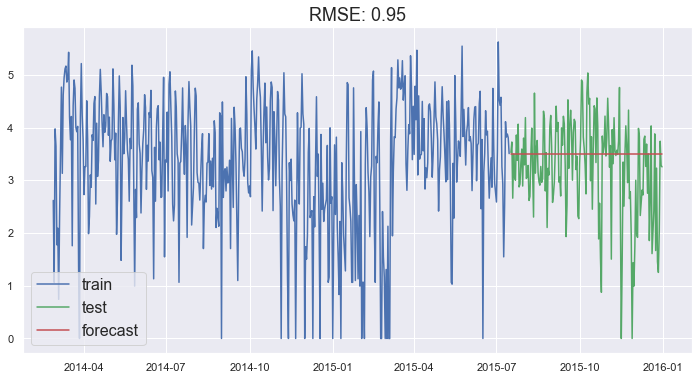

In [245]:
rmse_matrix['naive_rmse'] = np.nan
for station, sta_df in locGroup:
    
    sta_df = sta_df.sort_values('date')
    n_size = int(len(sta_df)*0.75)
    train_data = sta_df[1:n_size]
    test_data = sta_df[n_size+1:]
    dd = np.asarray(train_data['log_rev'])
    
    yhat = test_data.copy()
    yhat['naive'] = dd[len(dd)-1]
    
    naive_rmse = mean_squared_error(yhat['log_rev'], yhat['naive'], squared = False)
    #bl_mape = mean_absolute_percentage_error(sta_df['log_mins'][7:], bl_weekahead)
    print (f'{station}: baseline rmse for naive method is {naive_rmse:.3f}')
    print ('\n')
    
    rmse_matrix.loc[station,'naive_rmse']=naive_rmse
    
plot_forecast(train_data['log_rev'], test_data['log_rev'], yhat['naive'])
    

### 2) Average method

2494: baseline rmse for average method is 1.085


2496: baseline rmse for average method is 0.893


2498: baseline rmse for average method is 0.964


2499: baseline rmse for average method is 0.903


2501: baseline rmse for average method is 0.614


2537: baseline rmse for average method is 0.843


2540: baseline rmse for average method is 0.894


2547: baseline rmse for average method is 1.082


2563: baseline rmse for average method is 1.322


2570: baseline rmse for average method is 0.920




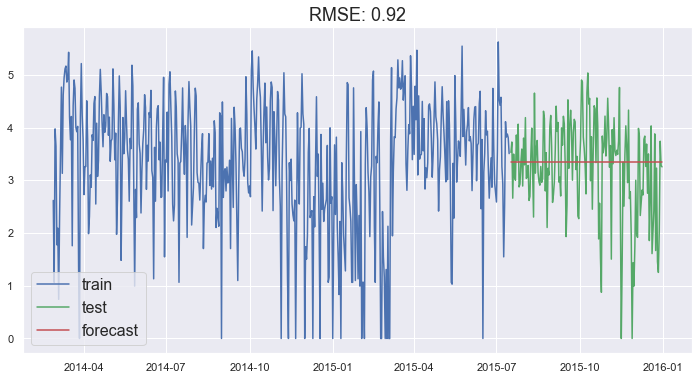

In [246]:
rmse_matrix['avg_rmse'] = np.nan

for station, sta_df in locGroup:
    
    sta_df = sta_df.sort_values('date')
    n_size = int(len(sta_df)*0.75)
    train_data = sta_df[1:n_size]
    test_data = sta_df[n_size+1:]
    
    
    yhat = test_data.copy()
    yhat['average'] = train_data['log_rev'].mean()
    
    average_rmse = mean_squared_error(yhat['log_rev'], yhat['average'], squared = False)
    #bl_mape = mean_absolute_percentage_error(sta_df['log_mins'][7:], bl_weekahead)
    print (f'{station}: baseline rmse for average method is {average_rmse:.3f}')
    print ('\n')
    rmse_matrix.loc[station,'avg_rmse']=average_rmse
    
plot_forecast(train_data['log_rev'], test_data['log_rev'], yhat['average'])
    

### 3) persistence method

2494: baseline rmse for average method is 1.017


2496: baseline rmse for average method is 1.030


2498: baseline rmse for average method is 1.063


2499: baseline rmse for average method is 0.917


2501: baseline rmse for average method is 0.552


2537: baseline rmse for average method is 0.908


2540: baseline rmse for average method is 1.175


2547: baseline rmse for average method is 1.319


2563: baseline rmse for average method is 1.427


2570: baseline rmse for average method is 1.002




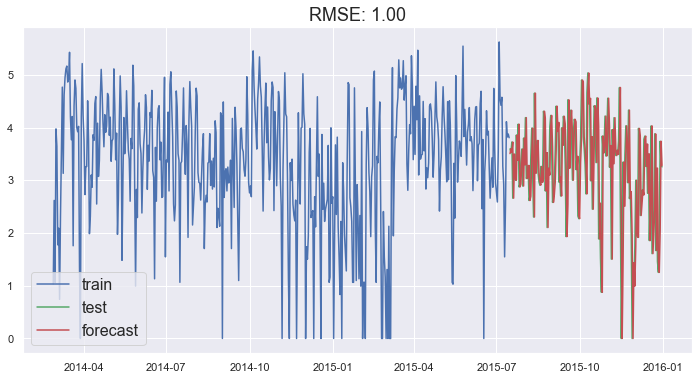

In [247]:
rmse_matrix['persist_rmse'] = np.nan

for station, sta_df in locGroup:
    
    sta_df = sta_df.sort_values('date')
    values = pd.DataFrame(sta_df['log_rev'])
    dfm1 = pd.concat([values.shift(1), values], axis=1)
    dfm1.columns = ['t-1', 't+1']
    dfm1.index = sta_df.index

    #X = dfm1.values
    n_size = int(len(sta_df)*0.75)
    train_df,test_df =dfm1[1:n_size], dfm1[n_size:]
    train_X, train_y = train_df.iloc[:,0], train_df.iloc[:,1]
    test_X, test_y = test_df.iloc[:,0], test_df.iloc[:,1]
    
    persist_rmse = mean_squared_error(test_y, test_X, squared = False)
    #bl_mape = mean_absolute_percentage_error(sta_df['log_mins'][7:], bl_weekahead)
    print (f'{station}: baseline rmse for average method is {persist_rmse:.3f}')
    print ('\n')
    rmse_matrix.loc[station,'persist_rmse']=persist_rmse
    
plot_forecast(train_X, test_y, test_X)

In [248]:
rmse_matrix

,naive_rmse,avg_rmse,persist_rmse
2494,1.117113,1.084632,1.017121
2501,0.651915,0.614340,0.551850
2496,1.103333,0.893162,1.029780
2498,0.926057,0.963503,1.063081
2499,0.960842,0.903324,0.917470
2537,1.323203,0.842885,0.908408
2540,1.361485,0.894074,1.175314
2547,1.155548,1.081582,1.318616
2563,1.751527,1.321703,1.427157
2570,0.952360,0.920238,1.001931


## Prediction with SARIMAX model

In [249]:
models_param = dict()


Start to process the auto arima fit for station: 2570
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,0)[7]             : AIC=1601.473, Time=1.48 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=1601.393, Time=0.66 sec
 ARIMA(1,0,0)(1,1,0)[7]             : AIC=1456.740, Time=2.31 sec
 ARIMA(0,0,1)(0,1,1)[7]             : AIC=1358.244, Time=2.29 sec
 ARIMA(0,0,1)(0,1,0)[7]             : AIC=1602.137, Time=1.34 sec
 ARIMA(0,0,1)(1,1,1)[7]             : AIC=1359.968, Time=2.51 sec
 ARIMA(0,0,1)(0,1,2)[7]             : AIC=1359.905, Time=35.05 sec
 ARIMA(0,0,1)(1,1,0)[7]             : AIC=1456.966, Time=2.03 sec
 ARIMA(0,0,1)(1,1,2)[7]             : AIC=1362.193, Time=38.48 sec
 ARIMA(0,0,0)(0,1,1)[7]             : AIC=1364.441, Time=2.18 sec
 ARIMA(1,0,1)(0,1,1)[7]             : AIC=inf, Time=2.41 sec
 ARIMA(0,0,2)(0,1,1)[7]             : AIC=1354.169, Time=2.96 sec
 ARIMA(0,0,2)(0,1,0)[7]             : AIC=1598.336, Time=1.55 sec
 ARIMA(0,0,2)(1,1,1)[7]             : AIC=1356.1

 ARIMA(0,0,3)(0,1,0)[7]             : AIC=1448.283, Time=1.51 sec
 ARIMA(0,0,3)(1,1,1)[7]             : AIC=1210.452, Time=2.86 sec
 ARIMA(0,0,3)(0,1,2)[7]             : AIC=1210.386, Time=11.92 sec
 ARIMA(0,0,3)(1,1,0)[7]             : AIC=1327.447, Time=2.07 sec
 ARIMA(0,0,3)(1,1,2)[7]             : AIC=1210.482, Time=12.42 sec
 ARIMA(1,0,3)(0,1,1)[7]             : AIC=1210.575, Time=2.86 sec
 ARIMA(0,0,3)(0,1,1)[7] intercept   : AIC=1211.340, Time=2.83 sec

Best model:  ARIMA(0,0,3)(0,1,1)[7]          
Total fit time: 184.374 seconds
RMSE:0.971
Analysis complete for station:2499, start next process


Start to process the auto arima fit for station: 2570
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,0)[7]             : AIC=1224.778, Time=1.57 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=1233.099, Time=0.40 sec
 ARIMA(1,0,0)(1,1,0)[7]             : AIC=1073.047, Time=1.97 sec
 ARIMA(0,0,1)(0,1,1)[7]             : AIC=973.320, Time=1.83 sec
 ARIMA(0,0,1)(0,1,0)[7]      

 ARIMA(1,0,2)(0,1,1)[7] intercept   : AIC=1339.445, Time=2.72 sec

Best model:  ARIMA(0,0,3)(0,1,1)[7] intercept
Total fit time: 138.980 seconds
RMSE:1.067
Analysis complete for station:2563, start next process


Start to process the auto arima fit for station: 2570
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,0)[7]             : AIC=1588.373, Time=1.13 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=1586.865, Time=0.41 sec
 ARIMA(1,0,0)(1,1,0)[7]             : AIC=1453.143, Time=1.81 sec
 ARIMA(0,0,1)(0,1,1)[7]             : AIC=1361.827, Time=1.79 sec
 ARIMA(0,0,1)(0,1,0)[7]             : AIC=1587.447, Time=1.06 sec
 ARIMA(0,0,1)(1,1,1)[7]             : AIC=1363.900, Time=1.92 sec
 ARIMA(0,0,1)(0,1,2)[7]             : AIC=1363.691, Time=8.74 sec
 ARIMA(0,0,1)(1,1,0)[7]             : AIC=1453.971, Time=1.69 sec
 ARIMA(0,0,1)(1,1,2)[7]             : AIC=1365.797, Time=9.36 sec
 ARIMA(0,0,0)(0,1,1)[7]             : AIC=1371.255, Time=1.75 sec
 ARIMA(1,0,1)(0,1,1)[7]       

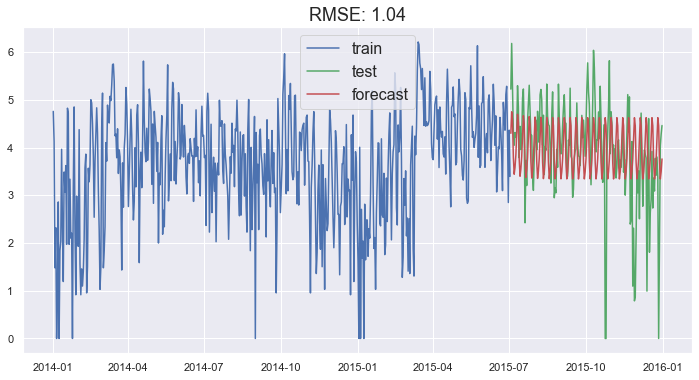

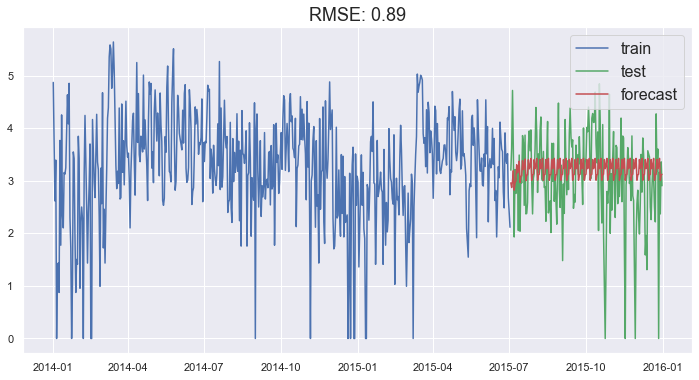

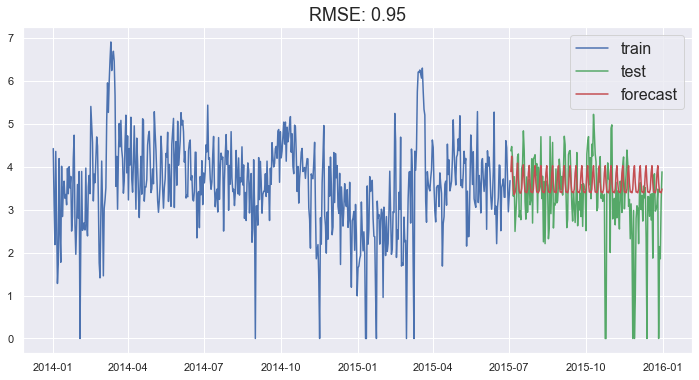

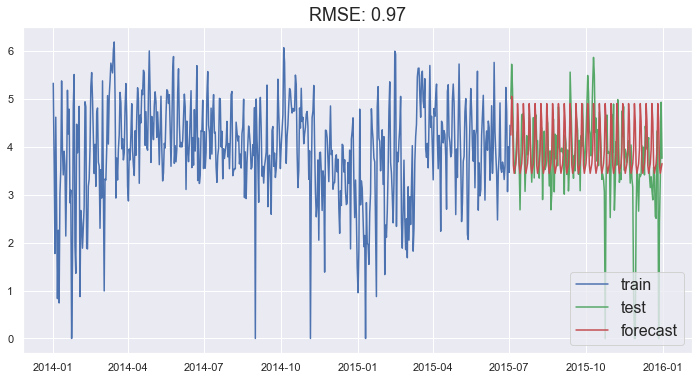

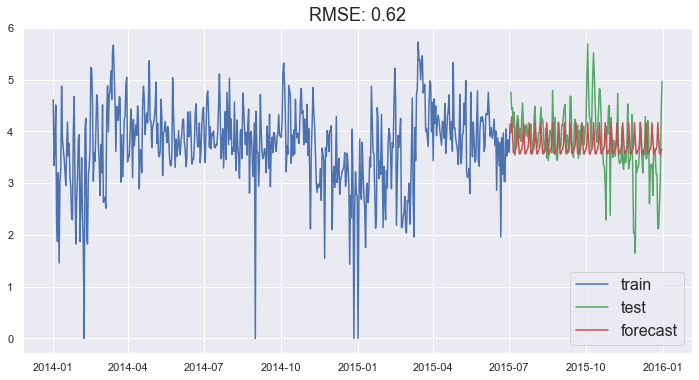

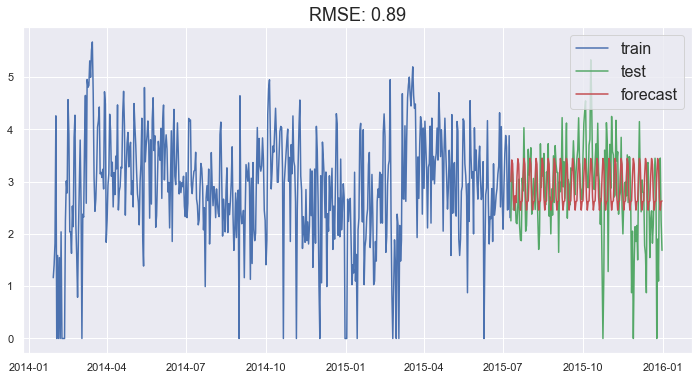

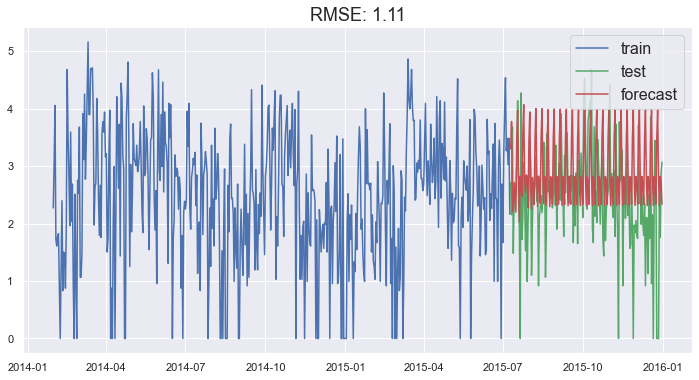

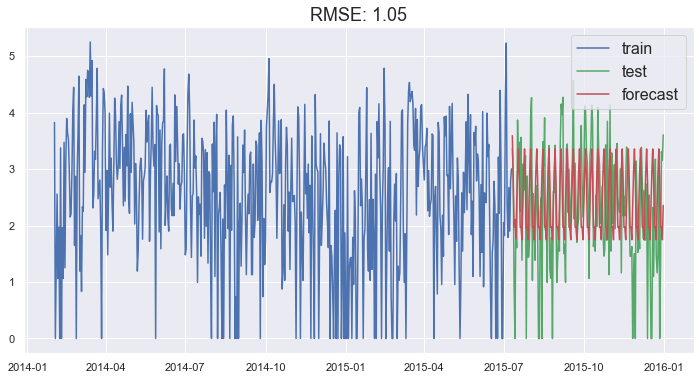

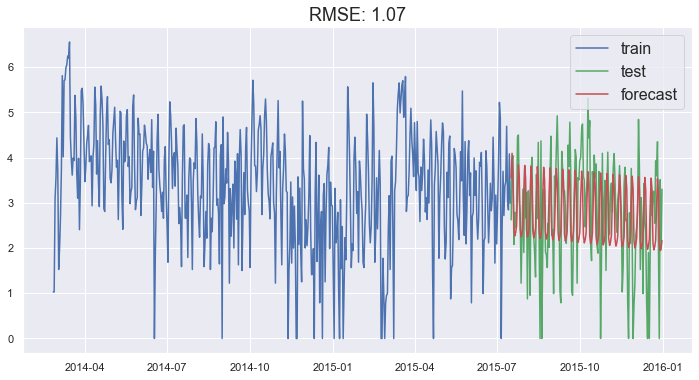

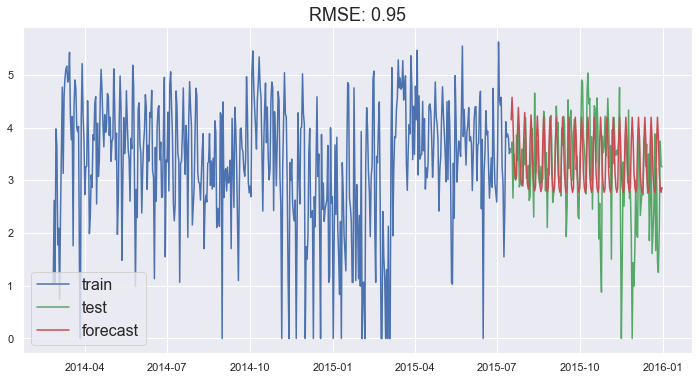

In [260]:
for id, sta_df in locGroup:
    
    print (f'Start to process the auto arima fit for station: {station}')
    sta_df = sta_df.sort_values('date')
    sta_df.drop('start_station_id',axis = 1, inplace = True)
    
    X_train, y_train, X_test, y_test = split_helper(sta_df, 'log_rev',0.25)

    
    srmodel= auto_arima(y_train, exogenous=X_train, start_p=1,start_q = 1,max_p=3, max_q=3,
                test = 'adf',#use the adftest to find optimal 'd'
                seasonal = True,m = 7,#seasonality 
                start_P = 0,D = 1,start_Q = 0,
                trace = True,
                error_action = 'ignore',
                suppress_warnings = True,
                stepwise = True, 
                with_intercept = False,
                approximation=False)
    
    
    res_model = srmodel.fit(y_train, exogeneous=X_train)

    y_forecast = res_model.predict(n_periods=len(X_test))
    rmse = mean_squared_error(y_test,y_forecast,squared=False)
    
    
    rmse_matrix.loc[id,'SARIMAX']=rmse
    models_param[id] = res_model
    
    print(f'RMSE:{rmse:.3f}')
    plot_forecast(y_train, y_test, y_forecast)
   
    print (f'Analysis complete for station:{id}, start next process')
    print ('\n')
    
    

In [261]:
rmse_matrix

,naive_rmse,avg_rmse,persist_rmse,SARIMAX
2494,1.117113,1.084632,1.017121,1.042287
2501,0.651915,0.614340,0.551850,0.617471
2496,1.103333,0.893162,1.029780,0.885782
2498,0.926057,0.963503,1.063081,0.953601
2499,0.960842,0.903324,0.917470,0.970638
2537,1.323203,0.842885,0.908408,0.890987
2540,1.361485,0.894074,1.175314,1.112861
2547,1.155548,1.081582,1.318616,1.049480
2563,1.751527,1.321703,1.427157,1.066562
2570,0.952360,0.920238,1.001931,0.948614


In [262]:
print(f'the diagsnotic plot for station id: {id}' )

the diagsnotic plot for station id: 2570


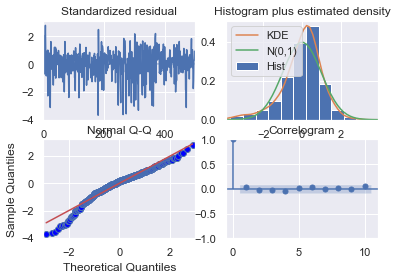

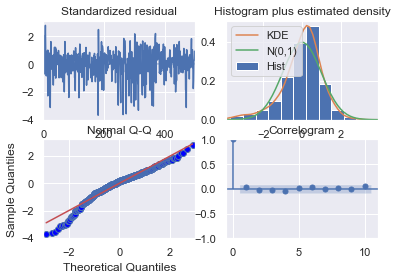

In [263]:
res_model.plot_diagnostics()



In [452]:
arima_repo = pd.DataFrame(columns = ['start_station_id','log_rev_pred'])

In [453]:
arima_repo

,start_station_id,log_rev_pred


In [456]:
for id, sta_df2 in predGroup:
    res_model = models_param[id]
    x_train = sta_df2.copy()
    x_train.drop('start_station_id', axis = 1, inplace = True)
    y_hat = res_model.predict(n_periods = 31)
    s_name = target_loc_df['start_station_name'][target_loc_df['start_station_id']==id].unique()
    arima_repo_res = pd.DataFrame({'start_station_id':id,  'log_rev_pred':y_hat, 'date':pd.date_range('2016-01-01', '2016-01-31')})
    
    arima_repo = arima_repo.append(arima_repo_res)

In [457]:
arima_repo

,start_station_id,log_rev_pred,date
0,2494,4.301655,2016-01-01
1,2494,4.752130,2016-01-02
2,2494,4.575568,2016-01-03
3,2494,3.802235,2016-01-04
4,2494,3.443474,2016-01-05
...,...,...,...
26,2570,2.800447,2016-01-27
27,2570,2.886699,2016-01-28
28,2570,3.748215,2016-01-29
29,2570,4.216561,2016-01-30


In [458]:
arima_sub = arima_repo.sort_values('date')

In [459]:
arima_sub.tail()

,start_station_id,log_rev_pred,date
30,2498,3.626266,2016-01-31
30,2496,3.288917,2016-01-31
30,2494,4.472774,2016-01-31
30,2563,3.523143,2016-01-31
30,2570,3.815779,2016-01-31


In [423]:
arima_sub['rev'] = np.exp(arima_sub['log_rev_pred'])-1

<AxesSubplot:xlabel='rev', ylabel='Density'>

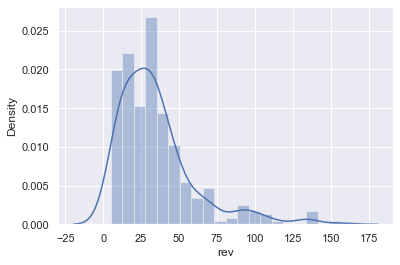

In [424]:
sns.distplot(arima_sub['rev'])

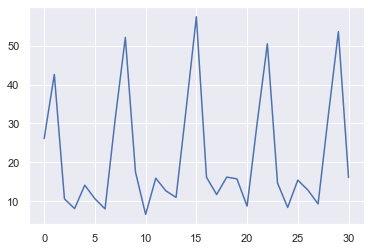

In [426]:
plt.plot(arima_sub['rev'][arima_sub['start_station_id']==2540])

### Try LSTM with one station, with help of a youtube tutorial

In [427]:
target_loc_df.columns


Index(['date', 'start_station_id', 'start_station_name', 'rev', 'dow',
       'quarter', 'day', 'month', 'year', 'is_holiday', 'Week_sin', 'Week_cos',
       'log_rev', 'is_sxsw', 'is_acl', 'TempHigh_F', 'TempAvg_F', 'TempLow_F',
       'HumidityHigh_Percent', 'HumidityAvg_Percent', 'HumidityLow_Percent',
       'VisibilityHigh_Miles', 'VisibilityAvg_Miles', 'VisibilityLow_Miles',
       'WindHigh_MPH', 'WindAvg_MPH', 'WindGust_MPH', 'Precipitation_Inches',
       'Events_id'],
      dtype='object')

In [428]:
features_col = ['log_rev','TempAvg_F', 'HumidityAvg_Percent','VisibilityAvg_Miles','WindAvg_MPH',
                 'Precipitation_Inches', 'Events_id','is_holiday','is_sxsw', 'is_acl']

In [429]:
guadalupe_ts = target_loc_df[target_loc_df['start_station_name']=='Guadalupe & 21st']

In [430]:
guadalupe_tsdf = guadalupe_ts[features_col]

In [431]:
guadalupe_tsdf.shape

(699, 10)

In [432]:
guadalupe_tsdf.head()

,log_rev,TempAvg_F,HumidityAvg_Percent,VisibilityAvg_Miles,WindAvg_MPH,Precipitation_Inches,Events_id,is_holiday,is_sxsw,is_acl
date,,,,,,,,,,
2014-02-01,3.828641,66,71.0,10.0,6.0,0.001,1,0,0,0
2014-02-02,0.000000,45,69.0,8.0,11.0,0.020,1,0,0,0
2014-02-03,1.223775,40,74.0,6.0,6.0,0.000,0,0,0,0
2014-02-04,2.557227,53,68.0,6.0,2.0,0.150,1,0,0,0
2014-02-05,1.064711,40,60.0,10.0,10.0,0.000,0,0,0,0


In [433]:
##[[log_mins1, Temp1, Humidity1, Vis1,...is_holiday1],[log_mins2,Temp2, Humidity2, Vis2,...is_holiday2],[6th]] [7th]
##[[log_mins2, Temp2, Humidity2, Vis2,...is_holiday2],[log_mins3, Temp3, Humidity3, Vis3,...is_holiday3],[7th]] [8th]
##[[log_mins3, Temp3, Humidity3, Vis3,...is_holiday3],[log_mins4, Temp4, Humidity4, Vis4,...is_holiday4],[8th]] [9th]

def prep_df(df, window_size = 7):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [r for r in df_as_np[i : i + window_size]]
        X.append(row)
        label = df_as_np[i + window_size][0]
        y.append(label)
    return np.array(X), np.array(y)
    
    

In [434]:
X, y = prep_df(guadalupe_tsdf)

In [435]:
X.shape, y.shape

((692, 7, 10), (692,))

In [436]:
y[:10]

array([3.37758752, 0.        , 1.96009478, 1.06471074, 3.47506723,
       1.25276297, 3.17805383, 3.89792408, 3.64283552, 3.53805656])

In [437]:
train_id = int(len(X) * 0.75)
val_id = train_id  + int(len(X) * 0.10)
train_id,val_id


(519, 588)

In [438]:
X_train, y_train = X[:train_id],y[:train_id]
X_val,y_val = X[train_id:val_id], y[train_id:val_id]
X_test, y_test = X[val_id:], y[val_id:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((519, 7, 10), (519,), (69, 7, 10), (69,), (104, 7, 10), (104,))

In [439]:
#standardized data:
X_train[:,:,0]

array([[3.8286414 , 0.        , 1.22377543, ..., 1.06471074, 1.97408103,
        0.        ],
       [0.        , 1.22377543, 2.55722731, ..., 1.97408103, 0.        ,
        3.37758752],
       [1.22377543, 2.55722731, 1.06471074, ..., 0.        , 3.37758752,
        0.        ],
       ...,
       [1.82454929, 4.23988687, 5.23537757, ..., 1.79175947, 2.67414865,
        1.90210753],
       [4.23988687, 5.23537757, 2.37024374, ..., 2.67414865, 1.90210753,
        2.79116511],
       [5.23537757, 2.37024374, 1.79175947, ..., 1.90210753, 2.79116511,
        3.0056826 ]])

In [440]:
temp_training_mean = np.mean(X_train[:,:,0])
temp_training_std = np.std(X_train[:,:,0])

def preprocessing(X):
    X[:,:,0] = (X[:,:,0]-temp_training_mean)/temp_training_std


In [441]:
preprocessing(X_train)
preprocessing(X_val)
preprocessing(X_test)

In [442]:
lstm_model = Sequential()

#lstm_model.add(LSTM(64,input_shape = (X_train.shape[1], X_train.shape[2])))
lstm_model.add(LSTM(64, batch_input_shape=(1, X_train.shape[1], 
                                         X_train.shape[2]), 
                                         stateful=True))
lstm_model.add(Dense(8, 'relu'))
lstm_model.add(Dense(1, 'linear'))

lstm_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, 64)                   19200     
_________________________________________________________________
dense (Dense)                (1, 8)                    520       
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    9         
Total params: 19,729
Trainable params: 19,729
Non-trainable params: 0
_________________________________________________________________


2022-04-15 00:21:23.958348: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [443]:
cp= ModelCheckpoint('lstm/',save_best_only = True)
lstm_model.compile(loss = MeanSquaredError(),optimizer = Adam(learning_rate = 0.0001), metrics = [RootMeanSquaredError()])

In [444]:
lstm_model.fit(X_train, y_train,validation_data = (X_val, y_val),epochs = 100, batch_size = 1, callbacks = [cp])

2022-04-15 00:21:30.676955: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/100
519/519 [==============================] - 2s 2ms/step - loss: 4.0528 - root_mean_squared_error: 1.9959 - val_loss: 1.3616 - val_root_mean_squared_error: 1.1669


2022-04-15 00:21:33.467026: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: lstm/assets


INFO:tensorflow:Assets written to: lstm/assets


Epoch 2/100
519/519 [==============================] - 1s 2ms/step - loss: 1.4296 - root_mean_squared_error: 1.1946 - val_loss: 1.4583 - val_root_mean_squared_error: 1.2076
Epoch 3/100
519/519 [==============================] - 1s 2ms/step - loss: 1.4779 - root_mean_squared_error: 1.2140 - val_loss: 1.3769 - val_root_mean_squared_error: 1.1734
Epoch 4/100
519/519 [==============================] - 1s 2ms/step - loss: 1.5659 - root_mean_squared_error: 1.2460 - val_loss: 1.5135 - val_root_mean_squared_error: 1.2303
Epoch 5/100
519/519 [==============================] - 1s 2ms/step - loss: 1.3594 - root_mean_squared_error: 1.1645 - val_loss: 1.3884 - val_root_mean_squared_error: 1.1783
Epoch 6/100
519/519 [==============================] - 1s 1ms/step - loss: 1.4767 - root_mean_squared_error: 1.2110 - val_loss: 1.3687 - val_root_mean_squared_error: 1.1699
Epoch 7/100
519/519 [==============================] - 1s 1ms/step - loss: 1.3603 - root_mean_squared_error: 1.1642 - val_loss: 1.3734 

INFO:tensorflow:Assets written to: lstm/assets


INFO:tensorflow:Assets written to: lstm/assets


Epoch 10/100
519/519 [==============================] - 1s 2ms/step - loss: 1.4420 - root_mean_squared_error: 1.1939 - val_loss: 1.3945 - val_root_mean_squared_error: 1.1809
Epoch 11/100
519/519 [==============================] - 1s 2ms/step - loss: 1.4287 - root_mean_squared_error: 1.1900 - val_loss: 1.3570 - val_root_mean_squared_error: 1.1649
Epoch 12/100
519/519 [==============================] - 1s 2ms/step - loss: 1.3213 - root_mean_squared_error: 1.1485 - val_loss: 1.2856 - val_root_mean_squared_error: 1.1338


INFO:tensorflow:Assets written to: lstm/assets


INFO:tensorflow:Assets written to: lstm/assets


Epoch 13/100
519/519 [==============================] - 1s 2ms/step - loss: 1.3419 - root_mean_squared_error: 1.1566 - val_loss: 1.3334 - val_root_mean_squared_error: 1.1547
Epoch 14/100
519/519 [==============================] - 1s 2ms/step - loss: 1.5101 - root_mean_squared_error: 1.2268 - val_loss: 1.3258 - val_root_mean_squared_error: 1.1514
Epoch 15/100
519/519 [==============================] - 1s 2ms/step - loss: 1.4157 - root_mean_squared_error: 1.1875 - val_loss: 1.3003 - val_root_mean_squared_error: 1.1403
Epoch 16/100
519/519 [==============================] - 1s 2ms/step - loss: 1.4361 - root_mean_squared_error: 1.1950 - val_loss: 1.3703 - val_root_mean_squared_error: 1.1706
Epoch 17/100
519/519 [==============================] - 1s 2ms/step - loss: 1.3318 - root_mean_squared_error: 1.1511 - val_loss: 1.2798 - val_root_mean_squared_error: 1.1313


INFO:tensorflow:Assets written to: lstm/assets


INFO:tensorflow:Assets written to: lstm/assets


Epoch 18/100
519/519 [==============================] - 1s 2ms/step - loss: 1.3001 - root_mean_squared_error: 1.1384 - val_loss: 1.2846 - val_root_mean_squared_error: 1.1334
Epoch 19/100
519/519 [==============================] - 1s 2ms/step - loss: 1.2920 - root_mean_squared_error: 1.1355 - val_loss: 1.3474 - val_root_mean_squared_error: 1.1608
Epoch 20/100
519/519 [==============================] - 1s 2ms/step - loss: 1.4629 - root_mean_squared_error: 1.2068 - val_loss: 1.3127 - val_root_mean_squared_error: 1.1457
Epoch 21/100
519/519 [==============================] - 1s 2ms/step - loss: 1.3545 - root_mean_squared_error: 1.1608 - val_loss: 1.2884 - val_root_mean_squared_error: 1.1351
Epoch 22/100
519/519 [==============================] - 1s 2ms/step - loss: 1.3458 - root_mean_squared_error: 1.1594 - val_loss: 1.3398 - val_root_mean_squared_error: 1.1575
Epoch 23/100
519/519 [==============================] - 1s 2ms/step - loss: 1.3129 - root_mean_squared_error: 1.1427 - val_loss: 1

INFO:tensorflow:Assets written to: lstm/assets


INFO:tensorflow:Assets written to: lstm/assets


Epoch 24/100
519/519 [==============================] - 1s 2ms/step - loss: 1.1950 - root_mean_squared_error: 1.0911 - val_loss: 1.2777 - val_root_mean_squared_error: 1.1303
Epoch 25/100
519/519 [==============================] - 1s 2ms/step - loss: 1.1660 - root_mean_squared_error: 1.0783 - val_loss: 1.2855 - val_root_mean_squared_error: 1.1338
Epoch 26/100
519/519 [==============================] - 1s 2ms/step - loss: 1.3209 - root_mean_squared_error: 1.1482 - val_loss: 1.3113 - val_root_mean_squared_error: 1.1451
Epoch 27/100
519/519 [==============================] - 1s 2ms/step - loss: 1.2112 - root_mean_squared_error: 1.0989 - val_loss: 1.2893 - val_root_mean_squared_error: 1.1355
Epoch 28/100
519/519 [==============================] - 1s 1ms/step - loss: 1.2504 - root_mean_squared_error: 1.1169 - val_loss: 1.3091 - val_root_mean_squared_error: 1.1441
Epoch 29/100
519/519 [==============================] - 1s 2ms/step - loss: 1.2309 - root_mean_squared_error: 1.1076 - val_loss: 1

In [445]:
lstm_pred = lstm_model.predict(X_test, batch_size = 1)

In [446]:
def plot_predictions1(model, X, y, start=0, end = 100):
    pred = model.predict(X,batch_size = 1).flatten()
    df = pd.DataFrame(data = {'Yhat': pred, 'Y': y})
    plt.plot(df['Yhat'][start:end])
    plt.plot(df['Y'][start:end])
    return df, mean_squared_error(y, pred,squared = False)



(         Yhat         Y
 0    3.033352  4.573680
 1    2.970712  2.116256
 2    2.534664  3.104587
 3    2.252158  2.208274
 4    2.066337  1.704748
 ..        ...       ...
 99   1.999706  0.000000
 100  1.963951  1.410987
 101  2.457471  3.310543
 102  2.172056  3.157000
 103  2.101074  3.608212
 
 [104 rows x 2 columns],
 1.077652915626587)

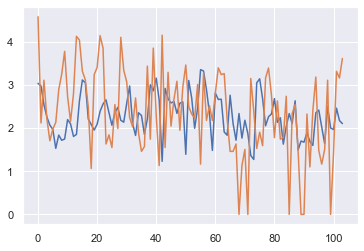

In [447]:
plot_predictions1(lstm_model, X_test,y_test,end = len(y))

In [ ]:
def plot_predictionsn1(model, X, y, start=0, end = 100):
    pred = model.predict(X).flatten()
    df = pd.DataFrame(data = {'Yhat': pred, 'Y': y})
    plt.plot(df['Yhat'][start:end])
    plt.plot(df['Y'][start:end])
    return df, mean_squared_error(y, pred)

